# Forecasting Rossmann Store Sales
In this notebook I describe the process I used to arrive at the final models. 

** Important info **
The things you should know before getting into it:
* The two best models were: 1. Seasonal ARIMA and 2. Multiplicative Holt-Winters
* The benchmark model which these two are compared against is the Random Walk model
* I am aiming to forecast 6 weeks ahead based on the client requirements. Since the store is only open 6 days a week this means the forecast is for 36 days. An important assumption that is that we ignore the Sunday values in our analysis (i..e they are left out of the data). In a model which is deployed to the client we will simply forecast \$0 of sales for each Sunday which makes sense

# EDA

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import time
import sys
from datetime import date, datetime

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [87]:
data=pd.read_csv('Rossman Sales.csv')
data.tail(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017189,1096,5,31/07/2015,9318,816,1,1,0,1
1017190,1097,5,31/07/2015,11443,2451,1,1,0,1
1017191,1098,5,31/07/2015,6410,780,1,1,0,1
1017192,1099,5,31/07/2015,12074,1370,1,1,0,1
1017193,1100,5,31/07/2015,7270,819,1,1,0,1
1017194,1101,5,31/07/2015,13501,1111,1,1,0,1
1017195,1102,5,31/07/2015,7211,704,1,1,0,0
1017196,1103,5,31/07/2015,8628,565,1,1,0,1
1017197,1104,5,31/07/2015,6878,472,1,1,0,0
1017198,1105,5,31/07/2015,7994,765,1,1,0,1


In [88]:
data['StateHolidaya']=(data['StateHoliday'] =='a').astype(int)
data['StateHolidayb']=(data['StateHoliday'] =='b').astype(int)
data['StateHolidayc']=(data['StateHoliday'] =='c').astype(int)
data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHolidaya,StateHolidayb,StateHolidayc
1017204,1111,5,31/07/2015,5723,422,1,1,0,1,0,0,0
1017205,1112,5,31/07/2015,9626,767,1,1,0,1,0,0,0
1017206,1113,5,31/07/2015,7289,720,1,1,0,1,0,0,0
1017207,1114,5,31/07/2015,27508,3745,1,1,0,1,0,0,0
1017208,1115,5,31/07/2015,8680,538,1,1,0,1,0,0,0


In [89]:
data['Open'] = data['Open'].apply(lambda x: 0 if np.isnan(x) else x)

data['has_sales'] = data['Sales'].apply(lambda x: x > 0)
data['has_customers'] = data['Customers'].apply(lambda x: x != 0)

date_format = '%d/%m/%Y'

#temporary column that have the date parsed in order to speed up further processing
data['_date'] = data['Date'].apply(lambda x: datetime.strptime(x, date_format))
data['month'] = data['_date'].apply(lambda x: x.month)
data['week_of_month'] = data['_date'].apply(lambda x: x.isocalendar()[1])
data['year'] = data['_date'].apply(lambda x: x.isocalendar()[0])
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHolidaya,StateHolidayb,StateHolidayc,has_sales,has_customers,_date,month,week_of_month,year
0,1,2,1/01/2013,0,0,0,0,a,1,1,0,0,False,False,2013-01-01,1,1,2013
1,2,2,1/01/2013,0,0,0,0,a,1,1,0,0,False,False,2013-01-01,1,1,2013
2,3,2,1/01/2013,0,0,0,0,a,1,1,0,0,False,False,2013-01-01,1,1,2013
3,4,2,1/01/2013,0,0,0,0,a,1,1,0,0,False,False,2013-01-01,1,1,2013
4,5,2,1/01/2013,0,0,0,0,a,1,1,0,0,False,False,2013-01-01,1,1,2013


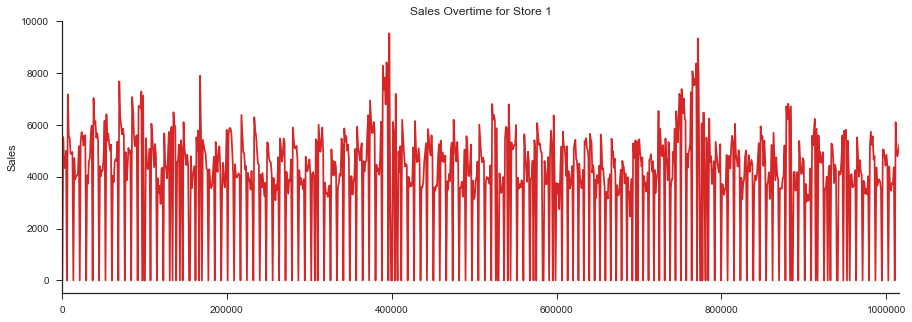

In [90]:
st = data[data['Store']==1]
y_1 = st['Sales']

fig, ax= plt.subplots(figsize=(15,5))
y_1.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.set_title('Sales Overtime for Store 1')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
fig.savefig('Images/EDA/store1sales.png')
plt.show()

In [58]:
g_open_cust = data.groupby(['Open', 'has_customers'])

print("Stores Open/Closed")
print(g_open_cust.agg({'Sales': np.sum, 'Open': np.sum}))

Stores Open/Closed
                         Sales    Open
Open has_customers                    
0    False                   0       0
1    False                   0      52
     True           5873180623  844340


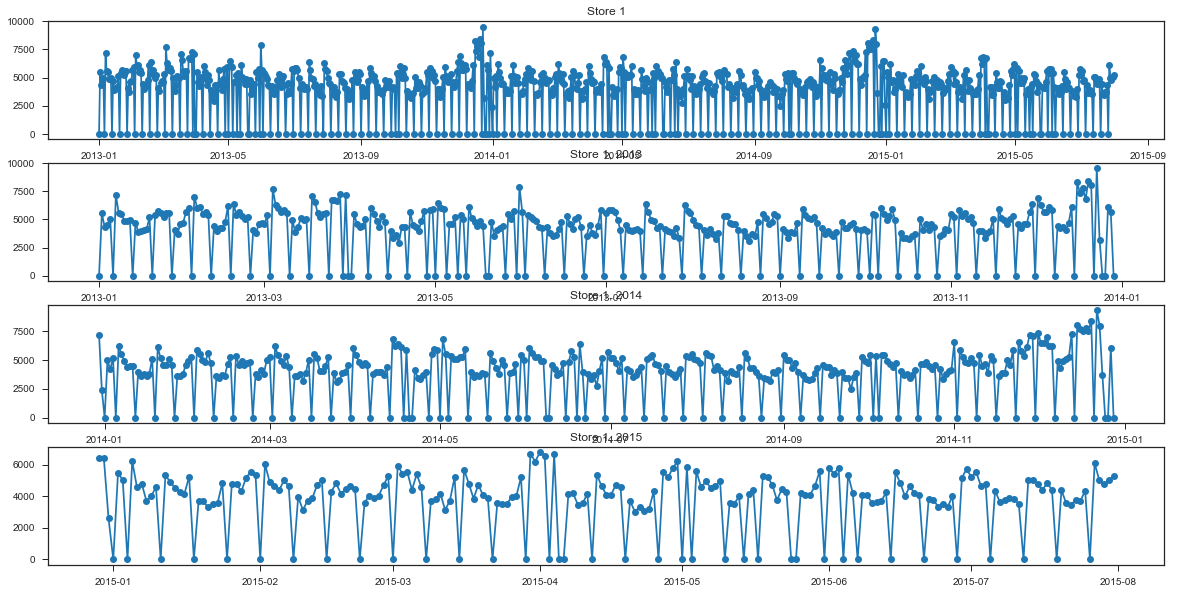

In [59]:
plt.figure(1,figsize=(20,10)) 
plt.subplot(411)
plt.plot_date(data.loc[data.Store==1,'_date'],data.loc[data.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1')  
plt.subplot(412)
data2013 = data.loc[data.year == 2013,:]
plt.plot_date(data2013.loc[data2013.Store==1,'_date'],data2013.loc[data2013.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1, 2013')
plt.subplot(413)
data2014 = data.loc[data.year == 2014,:]
plt.plot_date(data2014.loc[data2014.Store==1,'_date'],data2014.loc[data2014.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1, 2014') 
plt.subplot(414)
data2015 = data.loc[data.year == 2015,:]
plt.plot_date(data2015.loc[data2015.Store==1,'_date'],data2015.loc[data2015.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1, 2015') 
plt.savefig('Images/EDA/store1yearlysales.png')
plt.show()

In [84]:
#store_1 = data[data['Store']==1]
data = data[data['Sales']>0]


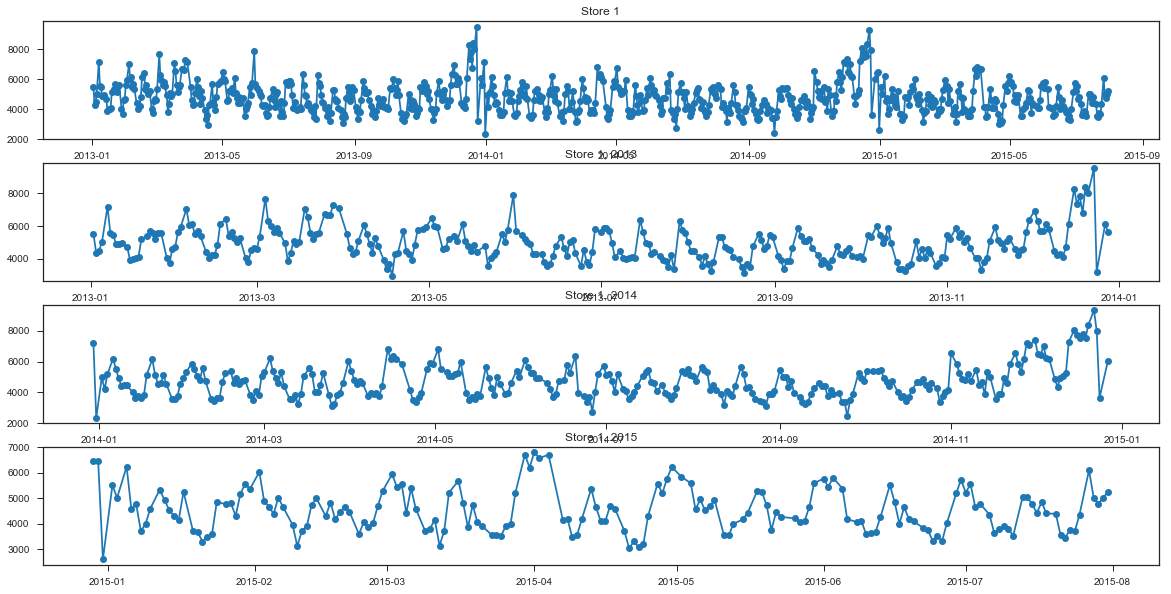

In [61]:
plt.figure(1,figsize=(20,10)) 
plt.subplot(411)
plt.plot_date(data.loc[data.Store==1,'_date'],data.loc[data.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1')  
plt.subplot(412)
data2013 = data.loc[data.year == 2013,:]
plt.plot_date(data2013.loc[data2013.Store==1,'_date'],data2013.loc[data2013.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1, 2013')
plt.subplot(413)
data2014 = data.loc[data.year == 2014,:]
plt.plot_date(data2014.loc[data2014.Store==1,'_date'],data2014.loc[data2014.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1, 2014') 
plt.subplot(414)
data2015 = data.loc[data.year == 2015,:]
plt.plot_date(data2015.loc[data2015.Store==1,'_date'],data2015.loc[data2015.Store==1,'Sales'],linestyle='-') 
plt.title('Store 1, 2015') 
plt.savefig('Images/EDA/store1yearlysalesWithout0.png')
plt.show()

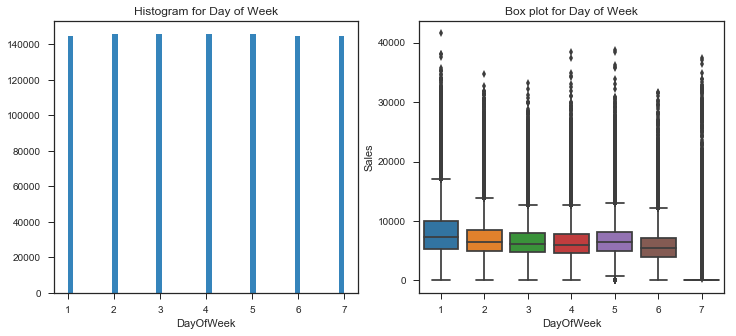

In [91]:
fig, ax=plt.subplots(1,2, figsize=(12,5))
sns.distplot(data['DayOfWeek'], kde=None, ax=ax[0], hist_kws={'alpha': 0.9})
ax[0].set(title='Histogram for Day of Week')
sns.boxplot(x='DayOfWeek', y='Sales', data=data, orient='v', ax=ax[1])
ax[1].set(title='Box plot for Day of Week')
plt.savefig('Images/EDA/boxplotdayweek.png')
plt.show()

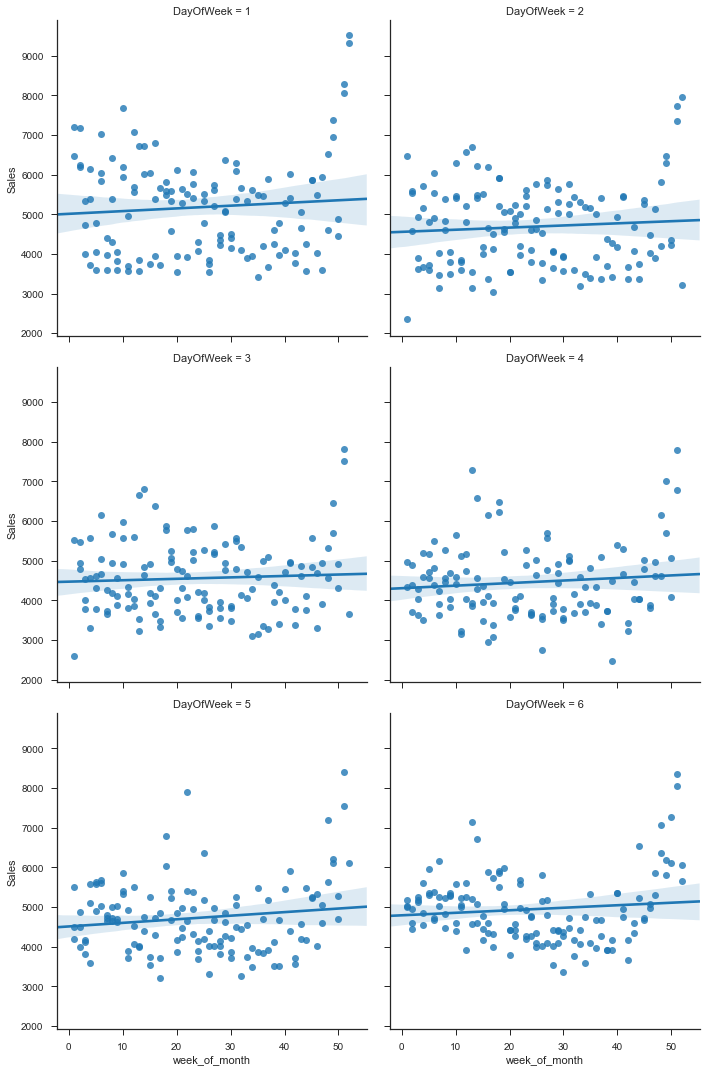

In [63]:
sns_plot = sns.lmplot(x='week_of_month', y='Sales', data=data[(data['Store']==1) & (data['Sales'] !=0)], 
           col='DayOfWeek', col_wrap=2);
fig = sns_plot.fig
fig.savefig('Images/EDA/dayWeekLMPlot.png')

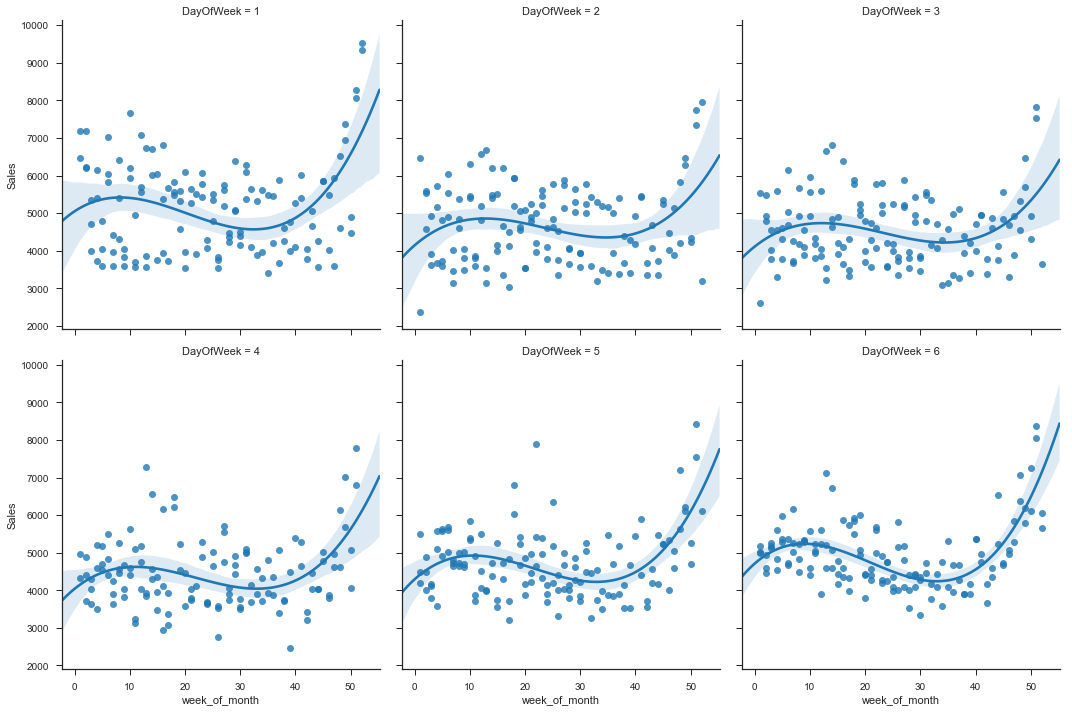

In [64]:
sns.lmplot(x='week_of_month', y='Sales', data=data[(data['Store']==1) & (data['Sales'] !=0)], 
           col='DayOfWeek', col_wrap=3, order=3);

fig = sns_plot.fig
fig.savefig('Images/EDA/dayWeekLMPlotOrder3.png')

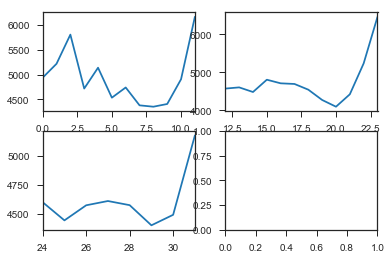

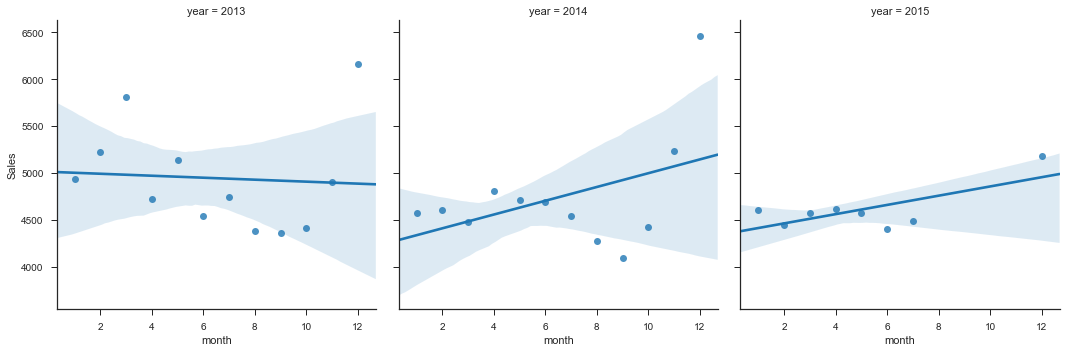

In [65]:
store = 1
data = data[(data['Store']==store) & (data['Sales'] !=0)]
ds = data.groupby(['year', 'month']).agg({'Sales': np.mean}).unstack(['year', 'month']).to_frame()

#reset index so year/month become columns
ds = ds.reset_index([0,1,2]).drop('level_0', axis=1)
ds.columns = ['year', 'month', 'Sales']

fig, ax = plt.subplots(2, 2)
ds[ds.year==2013].Sales.plot(ax=ax[0][0])
ds[ds.year==2014].Sales.plot(ax=ax[0][1])
ds[ds.year==2015].Sales.plot(ax=ax[1][0])

sns.lmplot(x='month', y='Sales', data=ds, col='year', col_wrap=3, order=1);

fig.savefig('Images/EDA/yearLMPlot.png')

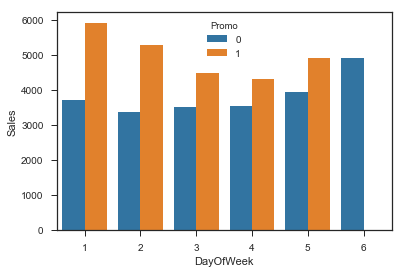

In [67]:
store, month, year = 1, 3, 2014
g_sym = data.groupby(['Store', 'year', 'month'])
g_store = g_sym.get_group((store, year, month))[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo']]
#remove all 0 sales, closed store and reshape
d = g_store[ (g_store.DayOfWeek != 7) & (g_store.Open != 0)].groupby(['DayOfWeek', 'Promo']).Sales.mean().to_frame()
d = d.reset_index()
ax = sns.barplot(data = d, x='DayOfWeek', y='Sales', hue='Promo')
fig = ax.get_figure()
fig.savefig('Images/EDA/DayWeekBar.png')

### Seasonality

In [68]:
data=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
data = data[data['Sales']>0]
data.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1111,5,5723,422,1,1,0,1
2015-07-31,1112,5,9626,767,1,1,0,1
2015-07-31,1113,5,7289,720,1,1,0,1
2015-07-31,1114,5,27508,3745,1,1,0,1
2015-07-31,1115,5,8680,538,1,1,0,1


In [69]:
data['StateHolidaya']=(data['StateHoliday'] =='a').astype(int)
data['StateHolidayb']=(data['StateHoliday'] =='b').astype(int)
data['StateHolidayc']=(data['StateHoliday'] =='c').astype(int)
data = data.loc[:, data.dtypes!='object']
data.head(20)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHolidaya,StateHolidayb,StateHolidayc
Date,,,,,,,,,,
2013-01-01,85,2,4220,619,1,0,1,1,0,0
2013-01-01,259,2,6851,1444,1,0,1,1,0,0
2013-01-01,262,2,17267,2875,1,0,1,1,0,0
2013-01-01,274,2,3102,729,1,0,1,1,0,0
2013-01-01,335,2,2401,482,1,0,1,1,0,0
2013-01-01,353,2,3139,820,1,0,1,1,0,0
2013-01-01,423,2,9643,1751,1,0,1,1,0,0
2013-01-01,494,2,3113,527,1,0,1,1,0,0
2013-01-01,512,2,2646,625,1,0,1,1,0,0


In [70]:
store_1 = data[data['Store']==1]

In [71]:
y = store_1['Sales'].copy()
y.index = y.index.to_period(freq='D')

ts = store_1['Sales']

In [72]:
basic_decomposition = sm.tsa.seasonal_decompose(ts.values, model='multiplicative', freq=12) # We use 12 because that's how many days there are between sales

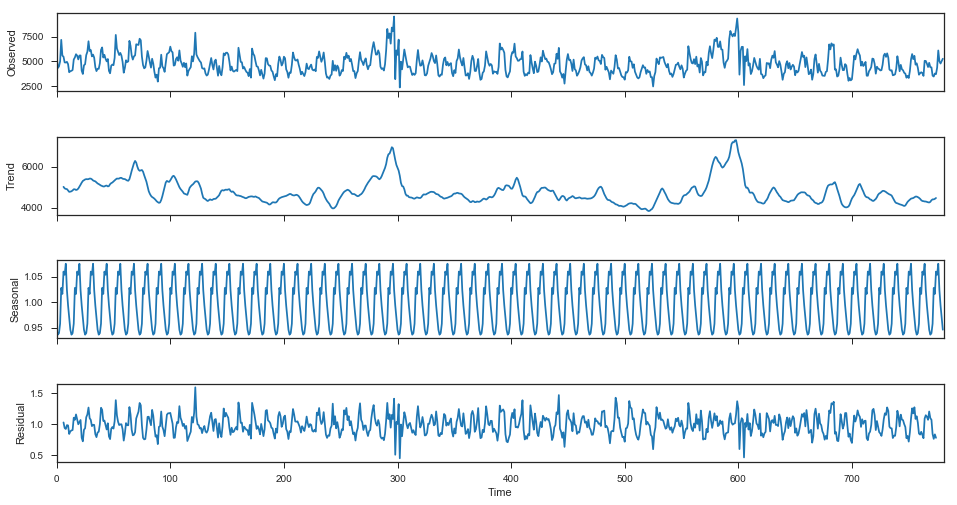

In [74]:
fig = plt.figure()  
fig = basic_decomposition.plot()  
fig.set_size_inches(15, 8)
fig.savefig('Images/EDA/SeasonalityBreakdown12')

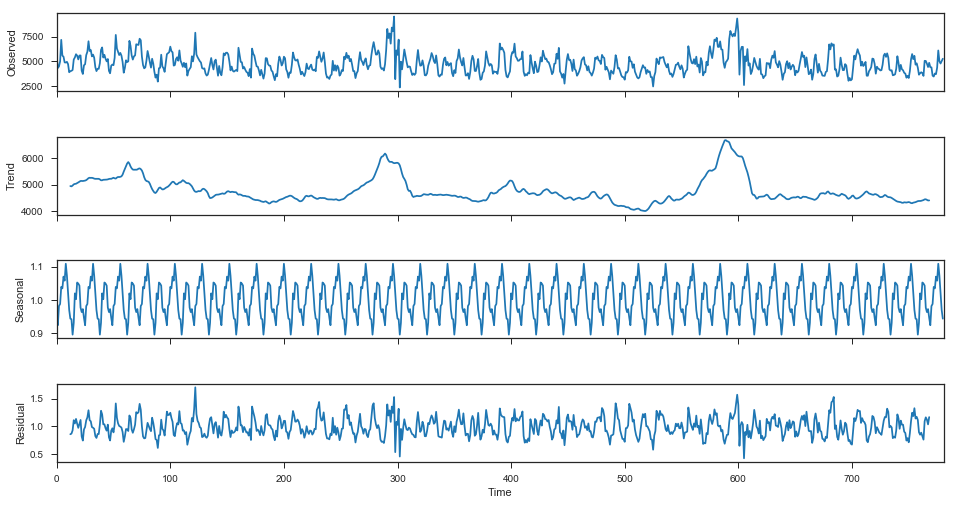

In [92]:
basic_decomposition = sm.tsa.seasonal_decompose(ts.values, model='multiplicative', freq=24) 
fig = basic_decomposition.plot()  
fig.set_size_inches(15, 8)
fig.savefig('Images/EDA/SeasonalityBreakdown24')

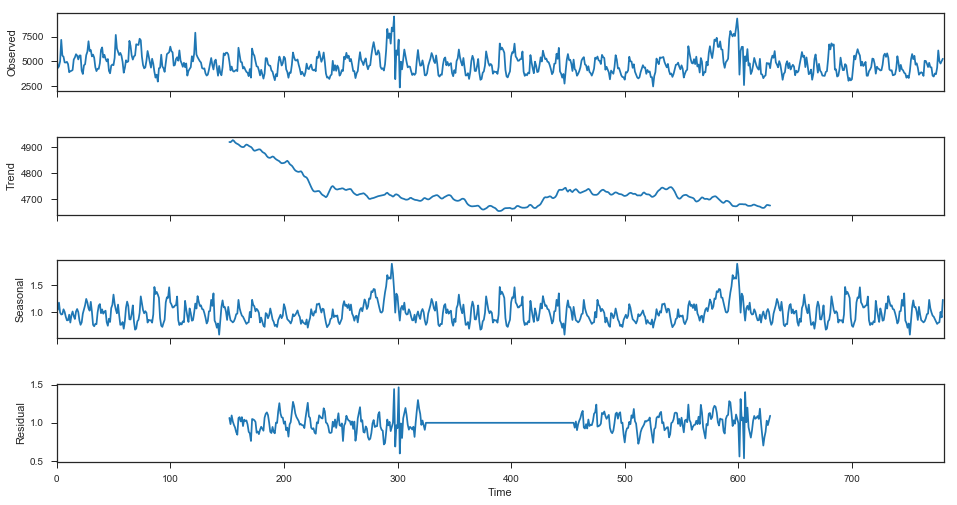

In [93]:
basic_decomposition = sm.tsa.seasonal_decompose(ts.values, model='multiplicative', freq=304) 
fig = basic_decomposition.plot()  
fig.set_size_inches(15, 8)
fig.savefig('Images/EDA/SeasonalityBreakdown304')

### Monthly Analysis

In [75]:
data=pd.read_csv('monthly_store1.csv', index_col='Date', parse_dates=True, dayfirst=True)
data.head()

,Year,Month,Sales
Date,,,
Jan-13,2013,1,128431
Feb-13,2013,2,125271
Mar-13,2013,3,145169
Apr-13,2013,4,118009
May-13,2013,5,110332


In [76]:
monthly_sales = data['Sales']

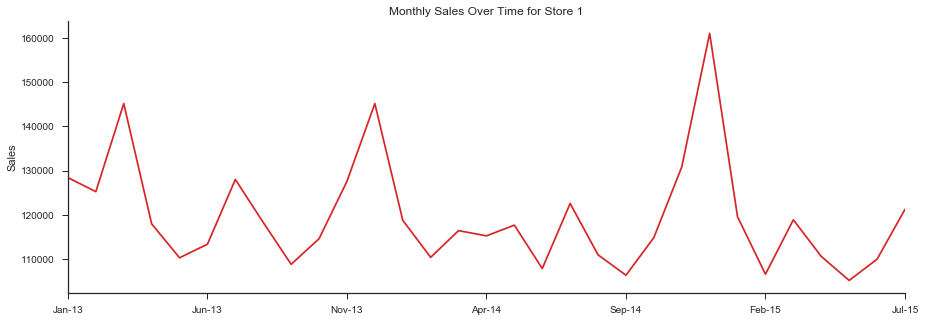

In [78]:
fig, ax= plt.subplots(figsize=(15,5))
monthly_sales.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales Over Time for Store 1')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.savefig('Images/EDA/monthlySalesStore1.png')
plt.show()

# Modelling

In [77]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## 1. Data Processing
To do this we do the following:
* First order the sales data by date in Excel (for simplicity)
* Import the entire Rossman Sales dataset by sorting by the date
* Remove an data points which are less than 0. It doesn't make sense to have negative sales
* Convert the holiday variables to dummy variables. These may or may not be used depending on which models are used.
* We conduct our analysis on the first store. With this first store we see that it is open every day of the week except Sunday. We will need to consider this in our analysis

In [78]:
data=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
data = data[data['Sales']>0]
data.index=data.index.to_period(freq='D')
data.tail(20)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1096,5,9318,816,1,1,0,1
2015-07-31,1097,5,11443,2451,1,1,0,1
2015-07-31,1098,5,6410,780,1,1,0,1
2015-07-31,1099,5,12074,1370,1,1,0,1
2015-07-31,1100,5,7270,819,1,1,0,1
2015-07-31,1101,5,13501,1111,1,1,0,1
2015-07-31,1102,5,7211,704,1,1,0,0
2015-07-31,1103,5,8628,565,1,1,0,1
2015-07-31,1104,5,6878,472,1,1,0,0


In [79]:
data['StateHolidaya']=(data['StateHoliday'] =='a').astype(int)
data['StateHolidayb']=(data['StateHoliday'] =='b').astype(int)
data['StateHolidayc']=(data['StateHoliday'] =='c').astype(int)
data = data.loc[:, data.dtypes!='object']
data.head(20)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHolidaya,StateHolidayb,StateHolidayc
Date,,,,,,,,,,
2013-01-01,85,2,4220,619,1,0,1,1,0,0
2013-01-01,259,2,6851,1444,1,0,1,1,0,0
2013-01-01,262,2,17267,2875,1,0,1,1,0,0
2013-01-01,274,2,3102,729,1,0,1,1,0,0
2013-01-01,335,2,2401,482,1,0,1,1,0,0
2013-01-01,353,2,3139,820,1,0,1,1,0,0
2013-01-01,423,2,9643,1751,1,0,1,1,0,0
2013-01-01,494,2,3113,527,1,0,1,1,0,0
2013-01-01,512,2,2646,625,1,0,1,1,0,0


In [80]:
store_1 = data[data['Store']==1]
y_1 = store_1['Sales']

# 3. Modelling
The primary goal of this analysis is to forecast the sales of Store 1. Logically this is dependent on time (i..e day of the week, time of the year, the season) so we focus on time-series based models. 

The outline should follow something similar to Assignment 1. First outline all the different models and then we will focus on two in particular. These will be selected based on their validation scores (i.e. RMSE).  

The two best models were: 
1. Seasonal ARIMA
2. SES

For the two selected models I will describe the following:
1. Data transformation
2. Model diagnostics
3. Any parameters used

## 3.1 Simple Exponential Smoothing

In [81]:
import forecast # you need to download the forecast.py file from the LMS

ses=forecast.ses(y_1)
ses.fit()
fitted=pd.Series(ses.smooth(), index=y_1.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.793 (0.039) 

 In-sample fit:
 MSE               625646.962
 Log-likelihood   -6320.015
 AIC               12646.031
 BIC               12660.013


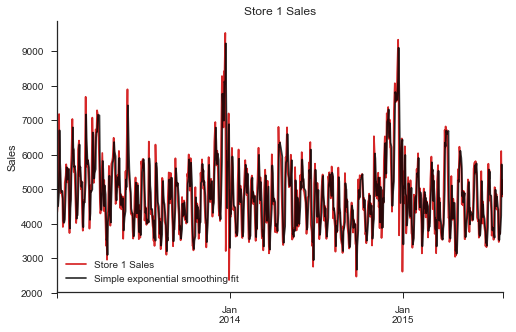

In [82]:
fig, ax= plt.subplots(figsize=(8,5))
y_1.plot(color=red, label='Store 1 Sales')
fitted.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.set_title('Store 1 Sales')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()
fig.savefig('SESFit.png')

### Model Diagnostics
We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are:
1. Residual plot.
2. Residula ACF.
3. Residual distribution plots.

In [83]:
resid=y_1-fitted

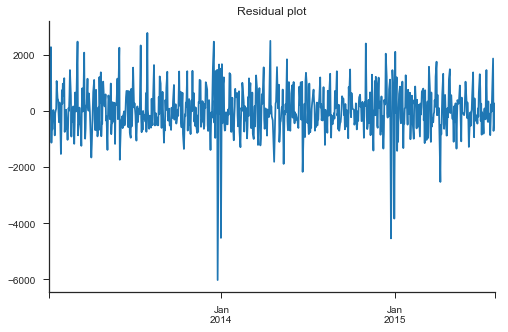

In [84]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()
fig.savefig('Images/SES/SESResiduals.png')

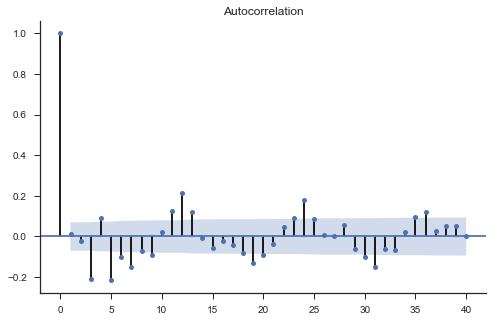

In [85]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()
fig.savefig('Images/SES/SESResidualACF.png')

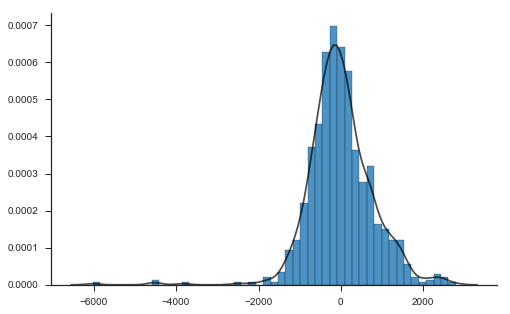

In [86]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    
    return fig, ax

hist(resid)
plt.savefig('Images/SES/SESResidualDistribution.png')
plt.show()


We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the January - due to Xmas sales), and are non-Gaussian.


## 3.2 Random Walk

This is going to be our benchmark model. It is important that you mention that our forecasts will be compared to this model. You will find this produces relatively good scores so we will have to work hard to beat it. Make sure you describe what the model consists of.

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials.
1. Specify the forecast horizon.
2. Create a range of dates or periods starting from the time index following the last observation in the data.
3. Generate the forecasts and store them in a series indexed by step 2.

Below, we generate point forecasts for one to 6 weeks (i.e. 36 days) after the end of the series.

In [87]:
h = 36 #forecast horizon
test=pd.period_range(start=y_1.index[-1]+1, periods=h, freq='D')
pred=pd.Series(np.repeat(y_1.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2015-08-01    5263
2015-08-02    5263
2015-08-03    5263
2015-08-04    5263
2015-08-05    5263
2015-08-06    5263
2015-08-07    5263
2015-08-08    5263
2015-08-09    5263
2015-08-10    5263
2015-08-11    5263
2015-08-12    5263
2015-08-13    5263
2015-08-14    5263
2015-08-15    5263
2015-08-16    5263
2015-08-17    5263
2015-08-18    5263
2015-08-19    5263
2015-08-20    5263
2015-08-21    5263
2015-08-22    5263
2015-08-23    5263
2015-08-24    5263
2015-08-25    5263
2015-08-26    5263
2015-08-27    5263
2015-08-28    5263
2015-08-29    5263
2015-08-30    5263
2015-08-31    5263
2015-09-01    5263
2015-09-02    5263
2015-09-03    5263
2015-09-04    5263
2015-09-05    5263
Freq: D, dtype: int64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [88]:
resid=y_1-y_1.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

806.577

Using the formulas from the lecture, the interval forecasts are as below.

In [89]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2015-08-01,3682.139,6843.861
2015-08-02,3027.325,7498.675
2015-08-03,2524.868,8001.132
2015-08-04,2101.278,8424.722
2015-08-05,1728.087,8797.913
2015-08-06,1390.697,9135.303
2015-08-07,1080.435,9445.565
2015-08-08,791.650,9734.350
2015-08-09,520.417,10005.583
2015-08-10,263.878,10262.122


### 3.2.1 Model Validation
We now perform model validation on the two models above, random walk and simple exponential smoothing. You will see that I perform model validation all throughout this document so these results will need to be combined into one large table at the end for presentation. 

* What the time period for real time forecasting is: we use values after 3rd January 2015 as our validation data. This is approximately 25.1% of our data.
* Benchmark: random walk
* Validation metric: RMSE

### 2 Weeks
We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods.

In [90]:
# Real time forecasting - use it as a template

validation=y_1['2015-07-18':].index 
start = y_1.index.get_loc('2015-07-18') 

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_1)):
    
    actual.append(y_1.iloc[i]) # actual value
    
    pred1.append(y_1.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y_1.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [91]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
RW,696.267,203.848
SES,901.836,297.455


In [92]:
# MAPE function
def mape(response, predicted):
    response = np.asarray(response)
    predicted = np.asarray(predicted)
    p_t_array = []
    
    # Go through all the elements
    for i in range(len(response)):
        
        p_t_element = np.abs(100*((response[i]-predicted[i])/response[i]))
        
        p_t_array.append(p_t_element)
        
    # Find MAPE
    mape = np.mean(p_t_array)
    return mape

In [93]:
# Real time forecasting - use it as a template

validation=y_1['2015-07-18':].index 
start = y_1.index.get_loc('2015-07-18') 

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_1)):
    
    actual.append(y_1.iloc[i]) # actual value
    
    pred1.append(y_1.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y_1.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

print(pred1)
print(actual)

[4852, 4406, 4395, 3558, 3464, 3769, 3706, 4364, 6102, 5011, 4782, 5020]
[4406, 4395, 3558, 3464, 3769, 3706, 4364, 6102, 5011, 4782, 5020, 5263]


In [94]:
# Random walk SES MAPE 2 weeks
mape_random_walk = mape(actual, pred1)
print(mape_random_walk.round(3))

mape_ses = mape(actual, pred2)
print(mape_ses.round(3))

10.49
14.16


### 6 Weeks

In [95]:
# Real time forecasting - use it as a template

validation=y_1['2015-06-20':].index 
start = y_1.index.get_loc('2015-06-20') 

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_1)):
    
    actual.append(y_1.iloc[i]) # actual value
    
    pred1.append(y_1.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y_1.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
RW,601.348,95.288
SES,829.934,126.291


In [96]:
# Random walk SES MAPE 2 weeks
mape_random_walk = mape(actual, pred1)
print(mape_random_walk.round(3))

mape_ses = mape(actual, pred2)
print(mape_ses.round(3))

9.65
13.419


### 26 weeks

In [97]:
# Real time forecasting - use it as a template

validation=y_1['2015-01-24':].index 
start = y_1.index.get_loc('2015-01-24') 

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_1)):
    
    actual.append(y_1.iloc[i]) # actual value
    
    pred1.append(y_1.iloc[i-1]) # random walk forecast
    
    model = forecast.ses(y_1.iloc[:i]) 
    model.fit()
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
RW,661.255,44.523
SES,922.091,57.884


In [98]:
# Random walk SES MAPE 2 weeks
mape_random_walk = mape(actual, pred1)
print(mape_random_walk.round(3))

mape_ses = mape(actual, pred2)
print(mape_ses.round(3))

11.378
15.653


## 3.3 Seasonal ARIMA

In [168]:
# Predefined plots

# Time series plot
def ts_plot(y, color=red):
    fig, ax= plt.subplots(figsize=(9,6))
    y.plot(color=color, ax=ax)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    sns.despine()
    return fig, ax

# ACF and PACF plots
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

#Histogram
def hist(y):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(y, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

### 3.3.1 Identification
To identify an appropriate ARIMA specification for the series, we start by creating a data frame to store the first differenced, seasonally differenced, and first and seasonally differenced series.

In [169]:
data=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
data = data[data['Sales']>0]
data.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1111,5,5723,422,1,1,0,1
2015-07-31,1112,5,9626,767,1,1,0,1
2015-07-31,1113,5,7289,720,1,1,0,1
2015-07-31,1114,5,27508,3745,1,1,0,1
2015-07-31,1115,5,8680,538,1,1,0,1


In [170]:
data['StateHolidaya']=(data['StateHoliday'] =='a').astype(int)
data['StateHolidayb']=(data['StateHoliday'] =='b').astype(int)
data['StateHolidayc']=(data['StateHoliday'] =='c').astype(int)
data = data.loc[:, data.dtypes!='object']
data.head(20)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHolidaya,StateHolidayb,StateHolidayc
Date,,,,,,,,,,
2013-01-01,85,2,4220,619,1,0,1,1,0,0
2013-01-01,259,2,6851,1444,1,0,1,1,0,0
2013-01-01,262,2,17267,2875,1,0,1,1,0,0
2013-01-01,274,2,3102,729,1,0,1,1,0,0
2013-01-01,335,2,2401,482,1,0,1,1,0,0
2013-01-01,353,2,3139,820,1,0,1,1,0,0
2013-01-01,423,2,9643,1751,1,0,1,1,0,0
2013-01-01,494,2,3113,527,1,0,1,1,0,0
2013-01-01,512,2,2646,625,1,0,1,1,0,0


In [171]:
store_1 = data[data['Store']==1]

In [172]:
y = store_1['Sales'].copy()
y.index = y.index.to_period(freq='D')

ts = store_1['Sales']

In [173]:
ts = np.log(ts)

In [174]:
basic_decomposition = sm.tsa.seasonal_decompose(ts.values, model='multiplicative', freq=12) # We use 304 because that's how many days there are approximately between consequtive dates

In [175]:
df=pd.DataFrame(y.copy())
df.columns.values[0]='original'
df['first_diff']=y-y.shift(1)
#df['second_diff']=y-y.shift(1)
df['seasonal_diff']=y-y.shift(12) # shift by 304 for daily data, excluding sundays.
df['diff']=df['first_diff']-df['first_diff'].shift(12)
df=df.dropna()
df.tail().round(3)

,original,first_diff,seasonal_diff,diff
Date,,,,
2015-07-27,6102,1738.0,1048.0,214.0
2015-07-28,5011,-1091.0,-31.0,-1079.0
2015-07-29,4782,-229.0,15.0,46.0
2015-07-30,5020,238.0,593.0,578.0
2015-07-31,5263,243.0,411.0,-182.0


Taking the first difference reveals a slow decay in ACF at the seasonal lags, suggesting the need for seasonal difference to stationarity.

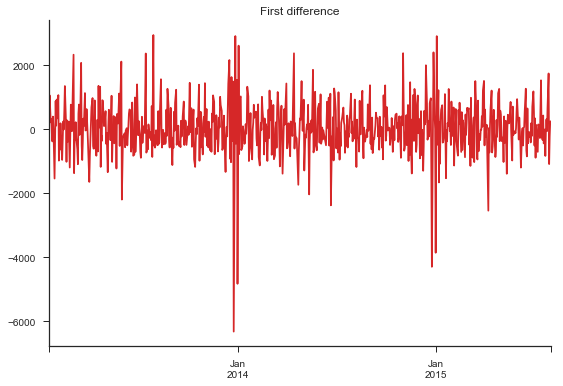

In [176]:
#fig, ax= plt.subplots()
#fig = plt.figure()
ts_plot(df['first_diff'])
plt.title('First difference')
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaFirstDiff.png')
plt.show()
#fig.savefig('Images/Seasonal ARIMA/SeasonalArimaFirstDiff.png')
#fig = sns_plot.fig


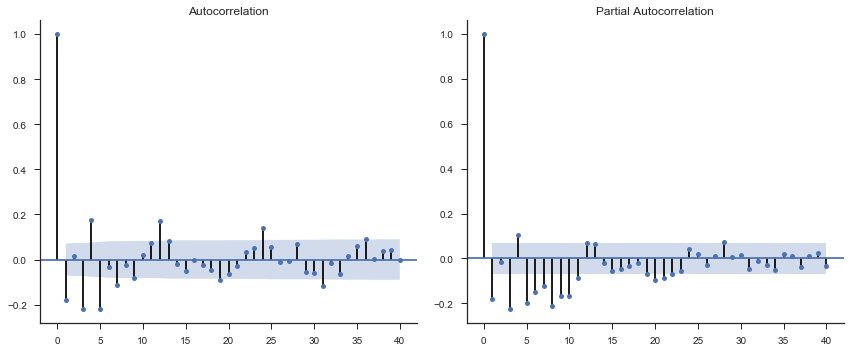

In [177]:
#fig, ax= plt.subplots()
acf_pacf_plot(df['first_diff'])
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaACFPCF.png')
plt.show()

Taking only the seasonal difference leads to a still clearly nonstationary series, confirming the need for both transformations. We can tell this because of the patterns of our ACF plot

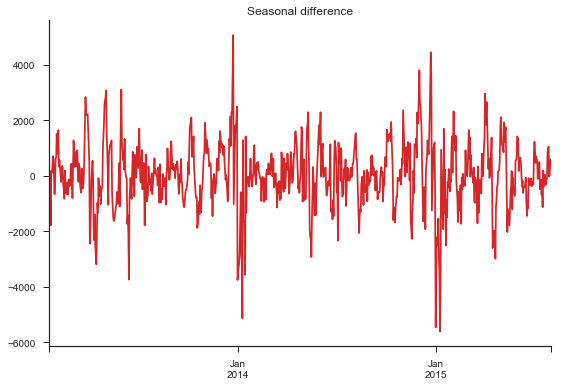

In [178]:
ts_plot(df['seasonal_diff'])
plt.title('Seasonal difference')
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaSeasonalDiff.png')
plt.show()

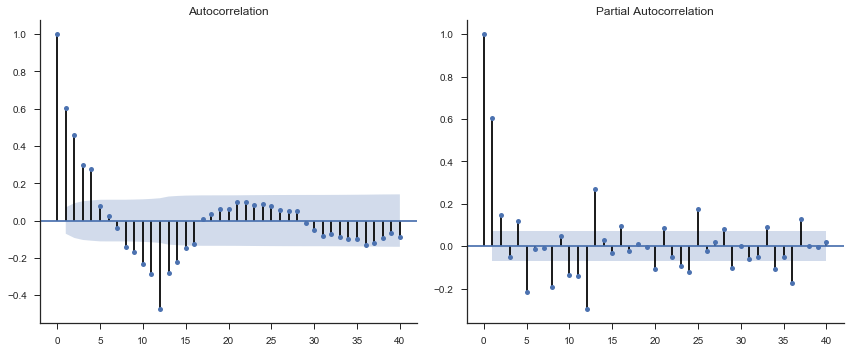

In [179]:
acf_pacf_plot(df['seasonal_diff'])
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaSeasonalACFPCF.png')
plt.show()

The next figure shows the first and seasonally differenced series, followed by the ACF and PACF plots. The ACF and PACF plots suggest the an AR(2) model: since the autocorrelations decrease gradually, while the partial autocorrelations display a clear cut-off after lag 2.

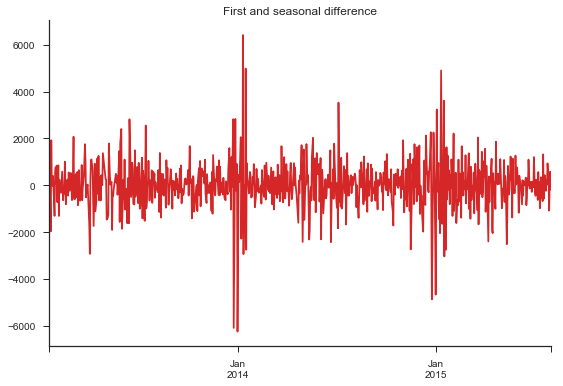

In [180]:
ts_plot(df['diff']) # first and seasonal difference
plt.title('First and seasonal difference')
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaFirstSeasDiff.png')
plt.show()

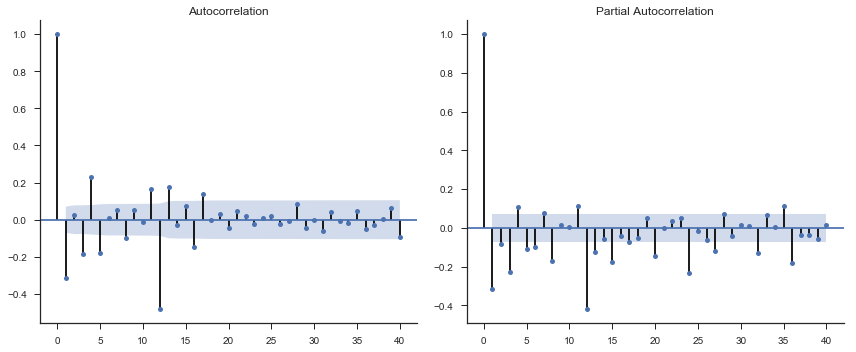

In [181]:
acf_pacf_plot(df['diff'])
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaFirstSeasACFPCF.png')
plt.show()

No seasonal AR or MA pattern is easily discernible from the ACF and PACFs plots above. Hence, I fit an AR(2) to model to the first and seasonally differenced series and examine the residuals for the remaining autocorrelations. The ACF and PACF plots for the residulal series seem to be consistent with a seasonal MA(1) model, due to a significant autocorrelation at lag 3 and significant partial autocorrelations at lags before 10.

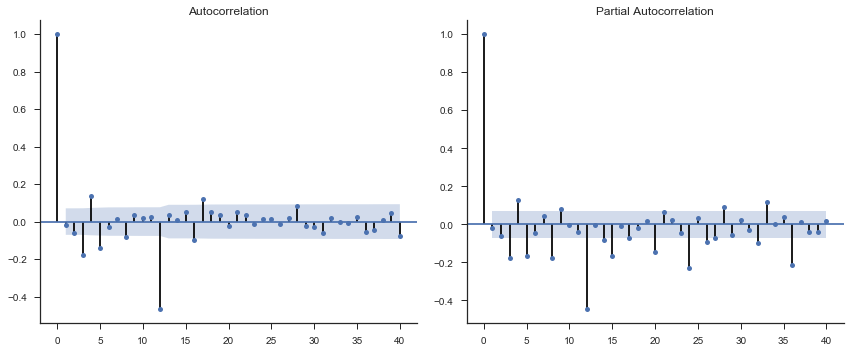

In [182]:
arima = sm.tsa.ARIMA(df['diff'], order=(2, 0, 0)).fit()
acf_pacf_plot(arima.resid)
plt.savefig('Images/Seasonal ARIMA/SeasonalArima200ACFPCF.png')
plt.show()

Hence, we select the ARIMA model with order=(2, 1, 0), seasonal_order=(0, 1, 1)

### 3.3.2 Estimation

In [183]:
sarima=sm.tsa.statespace.SARIMAX(y,  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit() # Need to fix this
print(sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  781
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -6205.991
Date:                            Thu, 02 Nov 2017   AIC                          12419.982
Time:                                    20:24:02   BIC                          12438.624
Sample:                                01-02-2013   HQIC                         12427.152
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2523      0.026     -9.537      0.000      -0.304      -0.200
ar.L2         -0.0674      0.040   

### 3.3.3 Diagnostics
Also include this in the report

In [184]:
resid=sarima.resid[6:] # the first 13 residuals are inialisation ones

Below are the residual plot, ACF and PACF for the ARIMA(2,1,0)(0,1,1) model. Therea are no apparent patterns in these plots, so that model seems to adequately capture time series dependence in the date.

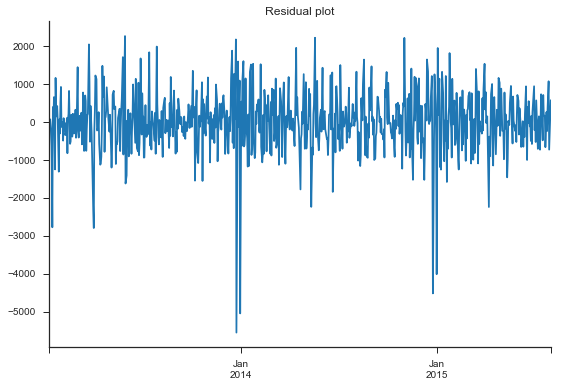

In [185]:
ts_plot(resid, color=blue)
plt.title('Residual plot')
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaResiduals.png')
plt.show()

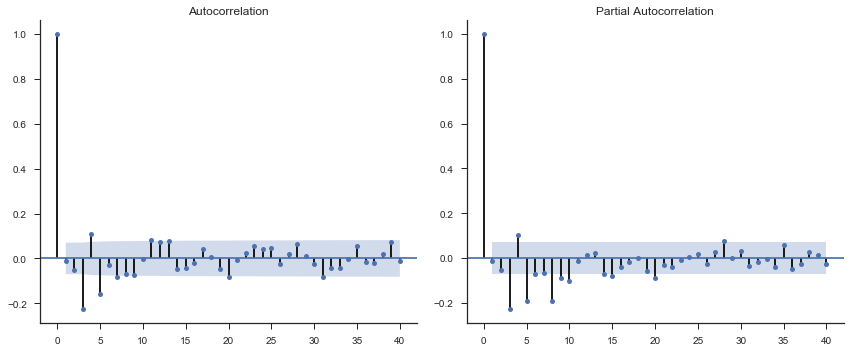

In [186]:
acf_pacf_plot(resid)
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaACFPCFDiagnostics.png')
plt.show()

The histogram of the residuals is ** not ** consistent with a normal or near normal distribution. This is a problem and you should mention this in the report. Does this violate any assumptions? (I think yes because of the distribution assumptions).

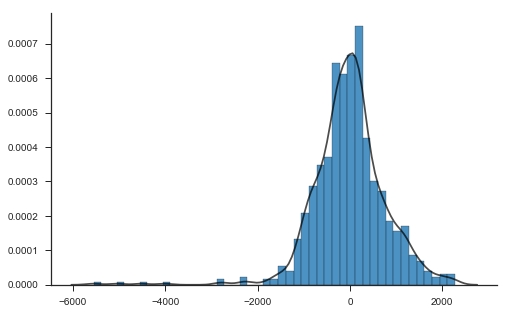

In [187]:
hist(resid)
plt.savefig('Images/Seasonal ARIMA/SeasonalArimaResidualsDiagnostics.png')
plt.show()

You can also include this table which provides a summary of the distribution for this model's residuals

In [188]:
sarima.summary().tables[2]

Ljung-Box (Q):,139.76,Jarque-Bera (JB):,2025.54
Prob(Q):,0.00,Prob(JB):,0.00
Heteroskedasticity (H):,1.39,Skew:,-1.05
Prob(H) (two-sided):,0.01,Kurtosis:,10.67


## Forecasts

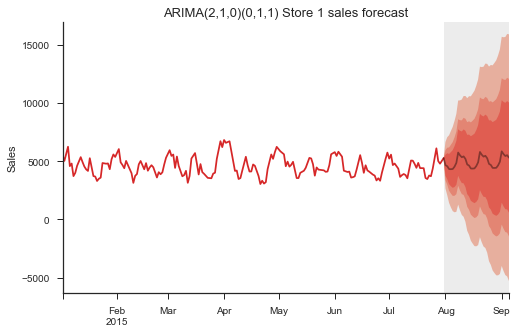

In [189]:
h=36 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred = sarima.forecast(steps=h)
y_pred =  pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.25)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['01-01-2015':], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(2,1,0)(0,1,1) Store 1 sales forecast', fontsize=13)
sns.despine()
plt.show()
fig.savefig('SeasonalARIMAForecast.png')

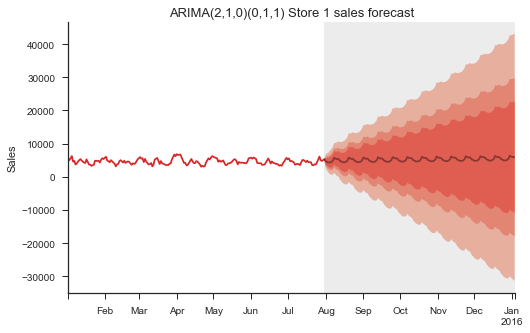

In [190]:
h=156 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred = sarima.forecast(steps=h)
y_pred =  pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.25)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['01-01-2015':], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(2,1,0)(0,1,1) Store 1 sales forecast', fontsize=13)
sns.despine()
plt.show()
fig.savefig('SeasonalARIMAForecast156.png')

## Exponential Smoothing
### Estimation
I estimate several Holt-Winters specifications, allowing for additive or multiplicative seasonality, a damped trend, and a log transformation. When modelling the level of the series, the model selection criteria and the overall fit suggest that a additive model without damping is the preferred specification for the data. Later, we will use a validation set to select between the multiplicative and log-additive models.

In [120]:
import forecast

ahw=forecast.holtwinters(y, additive=True, damped=False, m=304)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.470 (0.049)
 beta  (trend)    0.000 (0.039)
 delta (seasonal) 1.000 (0.111)
 
 In-sample fit:
 MSE               1240133.639
 RMSE              1113.613
 Log-likelihood   -6587.191
 AIC               13182.382
 BIC               13201.024


In [121]:
ahwd=forecast.holtwinters(y, additive=True, damped=True, m=304)
ahwd.fit()
ahwd.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.470 (0.052)
 beta  (trend)    0.000 (0.060)
 delta (seasonal) 1.000 (0.079)
 phi (damping)    0.612 (0.062)
 
 In-sample fit:
 MSE               1242755.486
 RMSE              1114.789
 Log-likelihood   -6588.016
 AIC               13186.031
 BIC               13209.334


In [122]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=304)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.062 (0.036)
 beta  (trend)    0.000 (0.029)
 delta (seasonal) 0.606 (0.064)
 
 In-sample fit:
 MSE               1340166.010
 RMSE              1157.655
 Log-likelihood   -6617.484
 AIC               13242.967
 BIC               13261.610


In [123]:
mhwd=forecast.holtwinters(y, additive=False, damped=True, m=304)
mhwd.fit()
mhwd.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.062 (0.026)
 beta  (trend)    0.000 (0.034)
 delta (seasonal) 0.607 (0.065)
 phi (damping)    0.657 (0.045)
 
 In-sample fit:
 MSE               1342999.362
 RMSE              1158.878
 Log-likelihood   -6618.308
 AIC               13246.617
 BIC               13269.920


In [124]:
ahw_log=forecast.holtwinters(np.log(y), additive=True, damped=False, m=304)
ahw_log.fit()
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.506 (0.049)
 beta  (trend)    0.000 (0.036)
 delta (seasonal) 1.000 (0.160)
 
 In-sample fit:
 MSE               0.054
 RMSE              0.232
 Log-likelihood    33.728
 AIC               -59.457
 BIC               -40.814


### Diagnostics
The figures below show the residual plot, ACF and PACF for the additive Holt-Winters model. We find that the exponential smoothing method is not a good fit for the data due to the presence of substantial remaining autocorrelation. The autocorrelation is due to a short run behaviour that is picked up by the AR(2) part of the ARIMA model above.

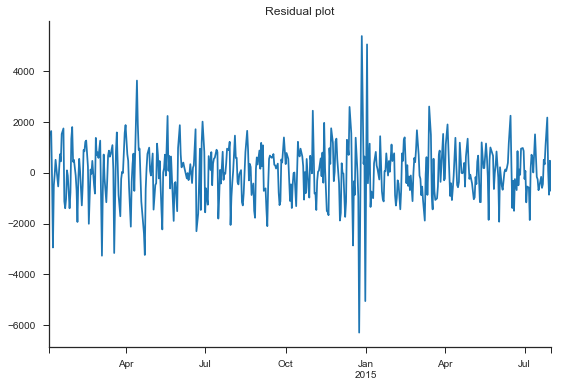

In [125]:
resid=pd.Series(ahw.resid, index=y.index).iloc[304:]
ts_plot(resid, color=blue)
plt.title('Residual plot')
plt.show()

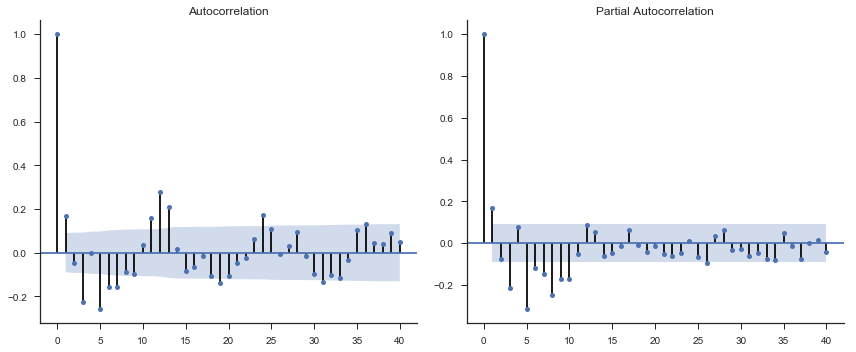

In [126]:
acf_pacf_plot(resid)
plt.show()

## Model Validation
The results clearly show that the ARIMA(2,1,0)(0,1,0) model outperforms exponential smoothing for forecasting.

### 2 Weeks

In [127]:
# Real time forecasting

y_float = y.astype(np.float64) # Have to convert otherwise get errors

validation=y['2015-07-18':].index 
start = y.index.get_loc('2015-07-18')
#recent = y.index.get_loc('2014-01-03')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters Additive', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=304)
    model.fit()
    results.iloc[j,1]=model.forecast(1)[0]
    
    # log holt winters
    model = forecast.holtwinters(np.log(y.iloc[:i]), additive=True, damped=True, m=304)
    model.fit()
    results.iloc[j,2]=np.exp(model.forecast(h=1)[0]+model.forecastvariance(h=1)[0]/2)
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast()[0]

In [128]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal RW,466.899,114.443
Holt-Winters Additive,1245.088,291.926
Log Holt-Winters,1217.085,260.890
Seasonal ARIMA,496.339,107.183


In [130]:
# MAPE function
def mape_arima_function(response, predicted):
    #response = np.asarray(response)
    #predicted = np.asarray(predicted)
    p_t_array = []
    
    # Go through all the elements
    for i in range(len(response)):
        print(i)
        p_t_element = np.abs(100*((response[i]-predicted[i])/response[i]))
        
        p_t_array.append(p_t_element)
        
    # Find MAPE
    mape = np.mean(p_t_array)
    return mape

In [131]:
# ARIMA MAPE
scores = results.as_matrix()
pred = scores[:,3]
actual = scores[:,4]

print(pred)
print(actual)

mape_arima_seasonal_score = mape_arima_function(actual, pred)
print(mape_arima_seasonal_score.round(3))



[ 4209.20750332  4245.26230584  4222.79096243  3738.69332193  3499.67502349
  3944.07993238  4025.57240912  5012.94181813  5739.83709938  5045.07563051
  4910.78679665  4683.7421337 ]
[ 4406.  4395.  3558.  3464.  3769.  3706.  4364.  6102.  5011.  4782.
  5020.  5263.]
0
1
2
3
4
5
6
7
8
9
10
11
8.907


#### 6 weeks

In [132]:
# Real time forecasting

y_float = y.astype(np.float64) # Have to convert otherwise get errors

validation=y['2015-06-20':].index 
start = y.index.get_loc('2015-06-20')
#recent = y.index.get_loc('2014-01-03')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters Additive', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=304)
    model.fit()
    results.iloc[j,1]=model.forecast(1)[0]
    
    # log holt winters
    model = forecast.holtwinters(np.log(y.iloc[:i]), additive=True, damped=True, m=304)
    model.fit()
    results.iloc[j,2]=np.exp(model.forecast(h=1)[0]+model.forecastvariance(h=1)[0]/2)
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast()[0]
    
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal RW,529.372,61.116
Holt-Winters Additive,1232.107,125.206
Log Holt-Winters,1203.939,115.809
Seasonal ARIMA,493.680,47.519


In [133]:
# ARIMA MAPE
scores = results.as_matrix()
pred = scores[:,3]
actual = scores[:,4]

print(pred)
print(actual)

mape_arima_seasonal_score = mape_arima_function(actual, pred)
print(mape_arima_seasonal_score.round(3))



[ 3567.5728773   3963.8983146   3825.40399664  3856.696631    3368.65225828
  3892.39832105  3737.07456829  4432.18177972  4781.25262418  5444.80415848
  5351.18205546  5191.98777706  4228.80142891  4612.36952305  4359.65676341
  3832.13789767  3740.28280822  4160.27858701  4248.99211118  4295.55668598
  4754.73965188  4830.74445431  4903.13236286  4137.30175307  4209.20750332
  4245.26230584  4222.79096243  3738.69332193  3499.67502349  3944.07993238
  4025.57240912  5012.94181813  5739.83709938  5045.07563051  4910.78679665
  4683.7421337 ]
[ 4097.  3846.  3762.  3346.  3533.  3317.  4019.  5197.  5735.  5223.
  5558.  4665.  4797.  4359.  3650.  3797.  3897.  3808.  3530.  5054.
  5042.  4767.  4427.  4852.  4406.  4395.  3558.  3464.  3769.  3706.
  4364.  6102.  5011.  4782.  5020.  5263.]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
9.407


### 26 weeks

In [134]:
# Real time forecasting

y_float = y.astype(np.float64) # Have to convert otherwise get errors

validation=y['2015-01-24':].index 
start = y.index.get_loc('2015-01-24')
#recent = y.index.get_loc('2014-01-03')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters Additive', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=304)
    model.fit()
    results.iloc[j,1]=model.forecast(1)[0]
    
    # log holt winters
    model = forecast.holtwinters(np.log(y.iloc[:i]), additive=True, damped=True, m=304)
    model.fit()
    results.iloc[j,2]=np.exp(model.forecast(h=1)[0]+model.forecastvariance(h=1)[0]/2)
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast()[0]
    
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Seasonal RW,994.592,64.521
Holt-Winters Additive,1277.935,67.331
Log Holt-Winters,1215.674,58.214
Seasonal ARIMA,639.677,39.927


In [135]:
# ARIMA MAPE
scores = results.as_matrix()
pred = scores[:,3]
actual = scores[:,4]

print(pred)
print(actual)

mape_arima_seasonal_score = mape_arima_function(actual, pred)
print(mape_arima_seasonal_score.round(3))



[ 2973.63961494  4777.22612444  4988.92059742  5240.88596964  4011.99596068
  5149.56108558  5433.60730173  5470.04967496  5494.76028782  5260.82804148
  4758.73384914  4246.97350398  4606.41521103  4979.37627266  4389.76767592
  3695.61798318  3403.55867904  4066.1910201   4495.67511383  5044.26588976
  4019.38109459  4752.36920702  4229.7178434   4301.12315185  4331.27048973
  4612.91902276  3880.11756958  4297.37032428  3749.07313101  4340.02817434
  4585.42172711  5147.59354633  5401.79102389  5481.07082276  5505.8451757
  4636.09982202  4969.69830269  4715.21973886  4046.61833784  4080.90752807
  3959.1545954   3774.87117991  3792.71819449  4958.53514868  5150.02313617
  4955.24833407  3940.53561974  4612.1006937   3894.37418062  3808.49971433
  3694.34414418  3833.57501202  3306.38142043  4208.63947193  4331.12131582
  5158.74855416  5858.89437256  6026.75680945  6587.04183955  6563.23546026
  6398.34579442  4594.39777161  4335.69874527  3865.87178495  3419.93526628
  4362.829444

## Forecast

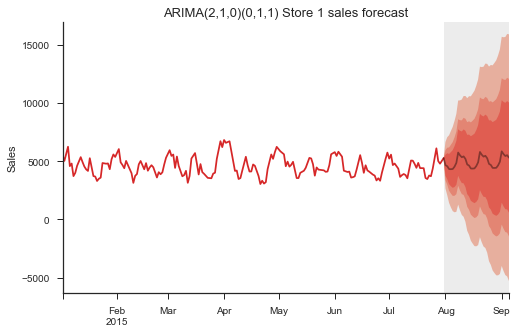

In [136]:
h=36 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred = sarima.forecast(steps=h)
y_pred =  pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.25)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['01-01-2015':], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(2,1,0)(0,1,1) Store 1 sales forecast', fontsize=13)
sns.despine()
plt.show()
fig.savefig('SeasonalARIMAForecast.png')

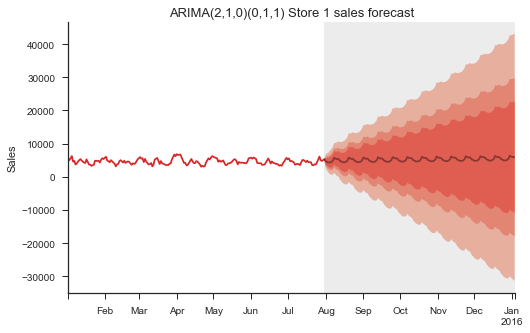

In [137]:
h=156 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred = sarima.forecast(steps=h)
y_pred =  pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.25)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['01-01-2015':], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(2,1,0)(0,1,1) Store 1 sales forecast', fontsize=13)
sns.despine()
plt.show()
fig.savefig('SeasonalARIMAForecast156.png')

### Point Forecasts - Seasonal ARIMA

In [191]:
# Real time forecasting

y_float = y.astype(np.float64) # Have to convert otherwise get errors

#validation=y['2015-06-20':].index 
start = y.index.get_loc('2015-07-31')
#recent = y.index.get_loc('2014-01-03')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters Additive', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA'])
#results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    #results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    #model = forecast.holtwinters(y.iloc[:i] , additive=True, damped=False, m=304)
    #model.fit()
    #results.iloc[j,1]=model.forecast(1)[0]
    
    # log holt winters
    #model = forecast.holtwinters(np.log(y.iloc[:i]), additive=True, damped=True, m=304)
    #model.fit()
    #results.iloc[j,2]=np.exp(model.forecast(h=1)[0]+model.forecastvariance(h=1)[0]/2)
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast()[j]
    
#from statlearning import rmse_jack

#table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
#for i in range(len(results.columns)-1):
 #   table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
#table.round(3)

In [192]:
results.head()

,Seasonal RW,Holt-Winters Additive,Log Holt-Winters,Seasonal ARIMA
Date,,,,
2015-07-31,0.0,0.0,0.0,4683.742134


In [193]:
model = sm.tsa.statespace.SARIMAX(y,  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()

In [194]:
model.forecast(steps=36)

2015-08-01    4654.437680
2015-08-02    4564.190695
2015-08-03    4319.683199
2015-08-04    4311.199585
2015-08-05    4327.217910
2015-08-06    4531.300672
2015-08-07    4853.634621
2015-08-08    5737.761175
2015-08-09    5501.659818
2015-08-10    5337.787594
2015-08-11    5408.749225
2015-08-12    5195.910839
2015-08-13    4713.604295
2015-08-14    4622.213442
2015-08-15    4369.488912
2015-08-16    4363.155421
2015-08-17    4379.184861
2015-08-18    4583.119969
2015-08-19    4905.490420
2015-08-20    5789.617712
2015-08-21    5553.513710
2015-08-22    5389.642104
2015-08-23    5460.603757
2015-08-24    5247.765324
2015-08-25    4765.458791
2015-08-26    4674.067938
2015-08-27    4421.343407
2015-08-28    4415.009916
2015-08-29    4431.039356
2015-08-30    4634.974464
2015-08-31    4957.344915
2015-09-01    5841.472207
2015-09-02    5605.368205
2015-09-03    5441.496599
2015-09-04    5512.458252
2015-09-05    5299.619819
Freq: D, dtype: float64

## Holt-winters exponential smoothing
We estimate several candidate specifications below. The AIC suggests an additive model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation.

Check slide 21 of Module 11 to find out whether additive or multiplicative is better.

For the purposes of this report we ignore these AIC scores. We should focus only on the validation method of selection. These AIC values provide a quick and easy way to compare similar models. Also AIC relies on a Gaussian assumtion which we see is not always appropriate.

In [196]:
ahw=forecast.holtwinters(y, additive=True, damped=False, m=12) # m=304 for daily data in our time series
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.703 (0.039)
 beta  (trend)    0.000 (0.037)
 delta (seasonal) 0.371 (0.058)
 
 In-sample fit:
 MSE               672557.297
 RMSE              820.096
 Log-likelihood   -6348.249
 AIC               12704.498
 BIC               12723.140


In [197]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.687 (0.039)
 beta  (trend)    0.000 (0.038)
 delta (seasonal) 0.349 (0.052)
 
 In-sample fit:
 MSE               670935.318
 RMSE              819.106
 Log-likelihood   -6347.306
 AIC               12702.612
 BIC               12721.255


In [198]:
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.688 (0.046)
 beta  (trend)    0.000 (0.052)
 delta (seasonal) 0.350 (0.060)
 phi (damping)    0.776 (0.030)
 
 In-sample fit:
 MSE               671811.748
 RMSE              819.641
 Log-likelihood   -6347.816
 AIC               12705.632
 BIC               12728.935


In [199]:
ahw_log=forecast.holtwinters(np.log(y), additive=True, damped=False, m=12)
ahw_log.fit()
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.711 (0.037)
 beta  (trend)    0.000 (0.036)
 delta (seasonal) 0.369 (0.036)
 
 In-sample fit:
 MSE               0.029
 RMSE              0.170
 Log-likelihood    274.181
 AIC               -540.362
 BIC               -521.719


The smoothed series based on the multiplicative method tracks the original series fairly well. However, there are still certain periods where it is not appropriate.

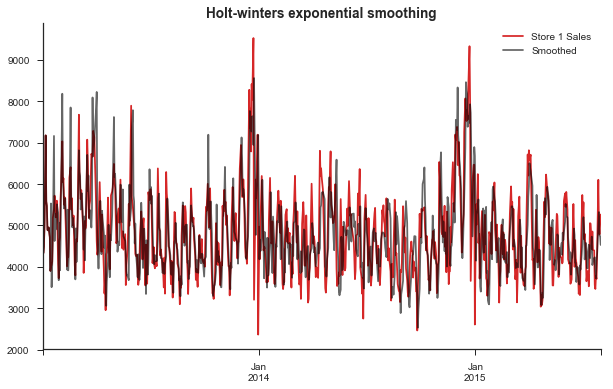

In [200]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Store 1 Sales')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title('Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
fig.savefig('To Add/Holt-WintersExSmoothing.png')
plt.show()

###  Model Diagnostics
We base the diagnostics on the additive without damping Holt-Winters model. This is because this type of model performed the best on the model validations section next.

The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals.

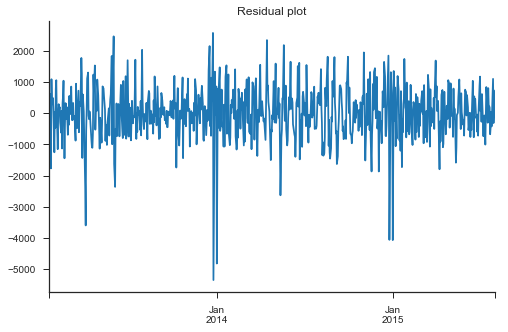

In [201]:
resid = (y-mhw.smooth())[12:] # If we remove the first 304 then we have no problems since they are used for initialisation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
fig.savefig('To Add/residualsHoltWint.png')
plt.show()

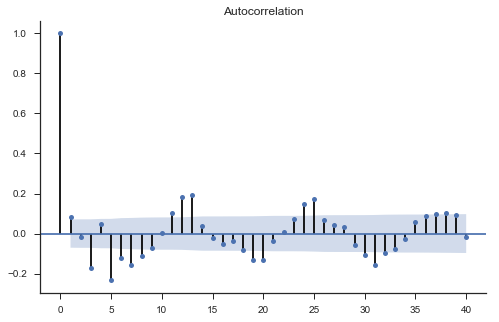

In [202]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
fig.savefig('To Add/ACFHoltWint.png')
plt.show()

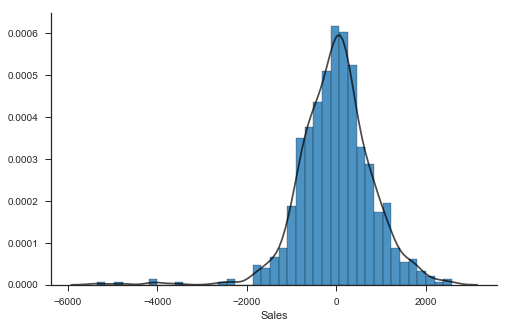

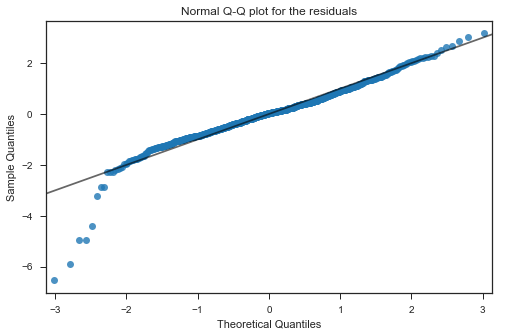

In [203]:
from forecast import histogram, qq_plot

histogram(resid)
plt.savefig('To Add/distHoltWint.png')
plt.show()

qq_plot(resid)
plt.savefig('To Add/qqHoltWint.png')
plt.show()

In [204]:
print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

Residual skewness: -0.865
Residual kurtosis: 5.467


### Model Validation
The real time forecasting analysis suggests that the additive without damping Holt Winters model for the  series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform slightly worse than seasonal random walk. This is interesting because we expected that the seasonal models to perform better than this. However, this may be due to inherent variable in the data which cannot be captured using time series modelling alone. 

At this point we can also compare these three models (Holt-winters to the previous two, i.e. SES and random walk). We see that these perform much worse and therefore, seasonal data may not be a good approach to this problem.

#### 2 Weeks

In [205]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y['2015-07-18':].index 
start = y.index.get_loc('2015-07-18')

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [206]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,466.90,114.44
Additive,729.00,96.54
Multiplicative,672.71,106.64
Log additive,701.10,98.49


In [207]:
# Additive, Multiplicative, Log additive MAPE 6 weeks
mape_additive = mape(actual, pred2)
print(mape_additive.round(3))

mape_multiplicative = mape(actual, pred3)
print(mape_multiplicative.round(3))

mape_log_ad = mape(actual, pred4)
print(mape_log_ad.round(3))

14.929
13.193
14.153


#### 6 Weeks

In [208]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y['2015-06-20':].index 
start = y.index.get_loc('2015-06-20')

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[304:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,529.37,61.12
Additive,779.54,70.66
Multiplicative,731.47,77.10
Log additive,782.68,79.14


In [209]:
# Additive, Multiplicative, Log additive MAPE 6 weeks
mape_additive = mape(actual, pred2)
print(mape_additive.round(3))

mape_multiplicative = mape(actual, pred3)
print(mape_multiplicative.round(3))

mape_log_ad = mape(actual, pred4)
print(mape_log_ad.round(3))

15.773
14.18
15.302


#### 26 Weeks

In [210]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y['2015-01-24':].index 
start = y.index.get_loc('2015-01-24')

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,994.59,64.52
Additive,857.43,46.82
Multiplicative,818.82,45.84
Log additive,867.32,47.65


In [211]:
# Additive, Multiplicative, Log additive MAPE 6 weeks
mape_additive = mape(actual, pred2)
print(mape_additive.round(3))

mape_multiplicative = mape(actual, pred3)
print(mape_multiplicative.round(3))

mape_log_ad = mape(actual, pred4)
print(mape_log_ad.round(3))

15.858
14.905
15.997
